# Fraud Detection

## Download data

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c ieee-fraud-detection

 63% 33.0M/52.5M [00:00<00:00, 139MB/s]
100% 52.5M/52.5M [00:00<00:00, 175MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 100MB/s]
 65% 31.0M/47.3M [00:00<00:00, 99.7MB/s]
100% 47.3M/47.3M [00:00<00:00, 158MB/s] 
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 186MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 165MB/s]


## Load libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score

import altair as alt
from altair.vega import v5
from IPython.display import HTML
from sklearn import preprocessing

import gc, datetime, random

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import confusion_matrix

## Exploration

In [43]:
sample_sub = pd.read_csv('sample_submission.csv.zip')
print(sample_sub.head())
del sample_sub

   TransactionID  isFraud
0        3663549      0.5
1        3663550      0.5
2        3663551      0.5
3        3663552      0.5
4        3663553      0.5


In [0]:
train_identity = pd.read_csv('train_identity.csv.zip')
train_transaction = pd.read_csv('train_transaction.csv.zip')
test_identity = pd.read_csv('test_identity.csv.zip')
test_transaction = pd.read_csv('test_transaction.csv.zip')

In [0]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [8]:
print(f'Train dataset: {train.shape[0]} rows & {train.shape[1]} columns')
print(f'Test dataset: {test.shape[0]} rows & {test.shape[1]} columns')

Train dataset: 590540 rows & 434 columns
Test dataset: 506691 rows & 433 columns


### Reduce memory

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [0]:
del train_identity, train_transaction, test_identity, test_transaction

### Treat missing data

In [12]:
data_null = train.isnull().sum()/len(train) * 100
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': data_null})
missing_data.shape

(414, 1)

In [0]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols
  
def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in data.columns if data[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols
  
def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    cols_to_drop.remove('isFraud')
    return cols_to_drop

In [14]:
cols_to_drop = get_useless_columns(train)

More than 90% null: 12
More than 90% repeated value: 67


Plotting missing data with seaborn

Text(0, 0.5, 'Missing rate')

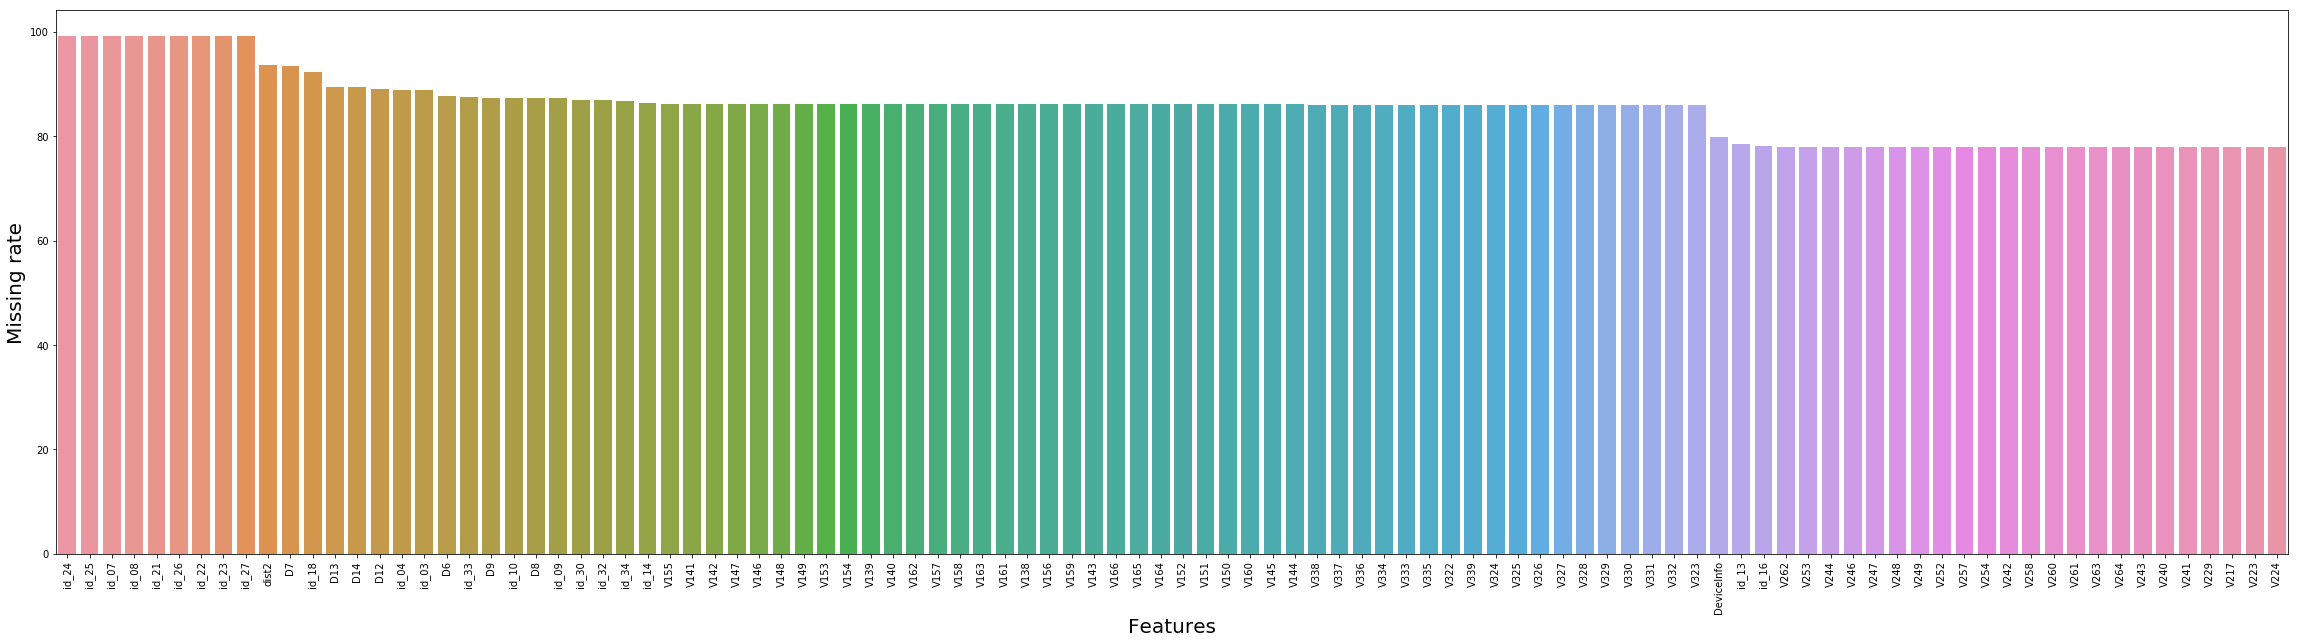

In [14]:
plt.subplots(figsize=(40,10))
plt.xticks(rotation='90')
sns.barplot(data_null.index[:100], data_null[:100])
plt.xlabel('Features', fontsize=20)
plt.ylabel('Missing rate', fontsize=20)

## Training

Cleaning data

In [0]:
train_clean = train.drop(cols_to_drop + ['TransactionID', 'TransactionDT'] , axis=1)

pairplot plotting with seaborn

Index(['isFraud', 'TransactionAmt', 'card1', 'card2'], dtype='object')


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


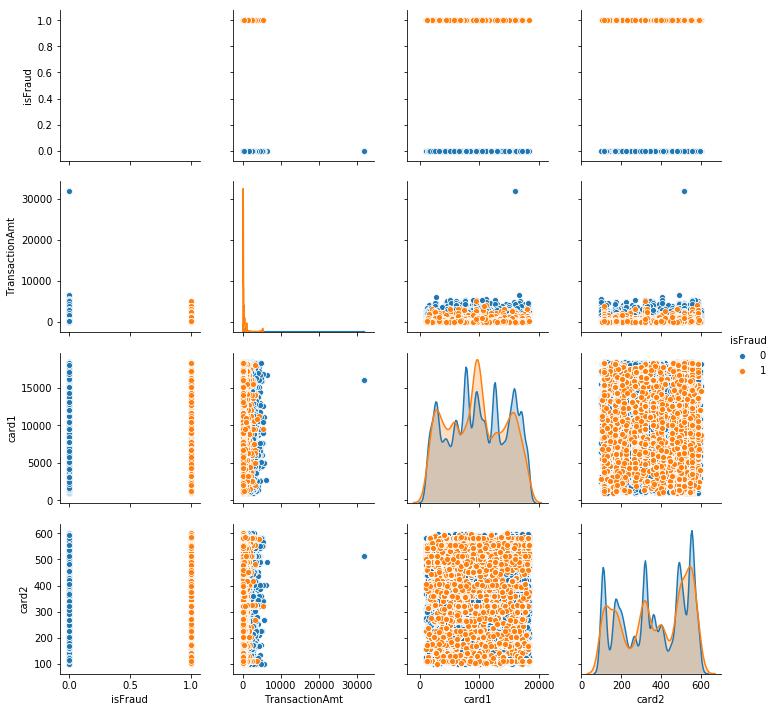

In [16]:
part_num_list = train_clean.select_dtypes(exclude=['object']).columns[:4]
print(part_num_list)
sns.pairplot(train_clean[part_num_list], hue='isFraud')

### Encoding cat cols

In [0]:
def encodeCategorical(data):
    for f in data.drop('isFraud', axis=1).columns:
        if data[f].dtype=='object':
            print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(data[f].values))
            data[f] = lbl.transform(list(data[f].values))
    return data

In [0]:
train_enc = encodeCategorical(train_clean)

### Replace null with median


In [0]:
train_median = train_enc.fillna(train_enc.median())

### Scaling features

In [0]:
def scale_data(data):
  for f in data.drop('isFraud', axis=1).columns:
    if data[f].dtype!='object': 
      #print(f)
      scaler = preprocessing.StandardScaler()
      data[[f]] = scaler.fit_transform(data[[f]])
  return data

In [0]:
train_scale = scale_data(train_median)

### Build X and y

In [0]:
X = train_scale.drop('isFraud', axis=1)
y = train_scale['isFraud']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Train LogisticRegression model

In [0]:
model = LogisticRegression(C=0.6)

In [39]:
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

score for training data

In [40]:
model.score(X_train, y_train)

0.9725370961504924

score for test data

In [41]:
model.score(X_test, y_test)

0.9717106512246061

seaborn plot of confusion matrix

Text(33.0, 0.5, 'True label')

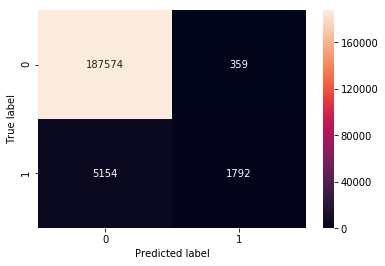

In [48]:
conf = confusion_matrix(y_test, model.predict(X_test))
ax = sns.heatmap(conf, annot=True, fmt="d")
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')